In [2]:
from google.colab import files
upload = files.upload()

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
# stem the words
from nltk.stem.porter import PorterStemmer
# split into train and test datasets
from sklearn.model_selection import train_test_split, cross_val_score
# extracting features from text using the bag of words model
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
df = pd.read_csv('IMDB Dataset.csv')

Exploring dataset

In [5]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [6]:
# let`s look at how clean is a dataset
df["review"].to_list()[:1]

["One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the f

In [7]:
#sentiment count
df['sentiment'].value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

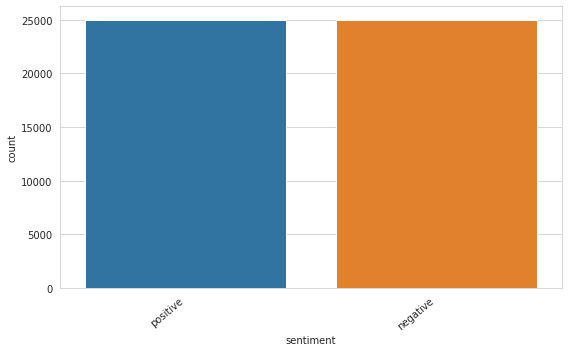

In [8]:
# let`s watch if sentiment classes are balanced
sns.set_style('whitegrid')
plt.figure(figsize=(8, 5))
ax = sns.countplot(x='sentiment', data=df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()

Data cleansing

In [9]:
# doing text cleanup
replace_by_space = re.compile('[/(){}\[\]\|@,;]')
remove_redundant_symbols = re.compile('[^0-9a-z #+_]')
remove_numbers = re.compile('[\d+]')
in_stopwords = set(stopwords.words('english'))

def cleaner(sentence):
    sentence = sentence.lower()  # make all words lowercase
    sentence = replace_by_space.sub(' ', sentence) # replace symbols by space in sentence
    sentence = remove_numbers.sub('', sentence) # delete numaric symbols
    sentence = remove_redundant_symbols.sub('', sentence)    # delete symbols which are in redundant symbols from sentence to reduce the number of noisy features
    sentence = ' '.join(word for word in sentence.split() if word not in in_stopwords) # delete stopwords from sentence
    return sentence

In [10]:
# applying cleaning function to reviews
df["review"] = df["review"].apply(cleaner) 

In [11]:
# watching how cleansed data is looking now
df["review"].to_list()[:2]

['one reviewers mentioned watching oz episode youll hooked right exactly happened mebr br first thing struck oz brutality unflinching scenes violence set right word go trust show faint hearted timid show pulls punches regards drugs sex violence hardcore classic use wordbr br called oz nickname given oswald maximum security state penitentary focuses mainly emerald city experimental section prison cells glass fronts face inwards privacy high agenda em city home manyaryans muslims gangstas latinos christians italians irish moreso scuffles death stares dodgy dealings shady agreements never far awaybr br would say main appeal show due fact goes shows wouldnt dare forget pretty pictures painted mainstream audiences forget charm forget romanceoz doesnt mess around first episode ever saw struck nasty surreal couldnt say ready watched developed taste oz got accustomed high levels graphic violence violence injustice crooked guards wholl sold nickel inmates wholl kill order get away well mannered

Further data preprocessing

In [12]:
# removing too short words in order to decrease the noise
df['review'] = df['review'].apply(lambda x: " ".join([word for word in x.split() if len(word)>3]))
# df.head()

In [13]:
# df["review"].to_list()[:2]

In [14]:
# stem the words
def stemming(sentence):
    stemmer = PorterStemmer()
    sentence= ' '.join([stemmer.stem(word) for word in sentence.split()])
    return sentence

# applying function on reviews
df['review']=df['review'].apply(stemming)


In [15]:
# applying function on reviews
df["review"].to_list()[:2]

['review mention watch episod youll hook right exactli happen mebr first thing struck brutal unflinch scene violenc right word trust show faint heart timid show pull punch regard drug violenc hardcor classic wordbr call nicknam given oswald maximum secur state penitentari focus mainli emerald citi experiment section prison cell glass front face inward privaci high agenda citi home manyaryan muslim gangsta latino christian italian irish moreso scuffl death stare dodgi deal shadi agreement never awaybr would main appeal show fact goe show wouldnt dare forget pretti pictur paint mainstream audienc forget charm forget romanceoz doesnt mess around first episod ever struck nasti surreal couldnt readi watch develop tast accustom high level graphic violenc violenc injustic crook guard wholl sold nickel inmat wholl kill order away well manner middl class inmat turn prison bitch lack street skill prison experi watch becom comfort uncomfort viewingthat touch darker side',
 'wonder littl product f

In [16]:
# Shuffel the dataset to make sure we get an equal distribution of the data before splitting into train and test sets
df = df.sample(frac=1)
df.head()

,review,sentiment
12775,movi first time sick school year compar made l...,positive
22985,ralph bakshi forgotten masterpiec fire rental ...,positive
15536,certainli without merit alreadi writerdirector...,negative
24724,sinc natali portman movi enjoy everi minut pla...,positive
26704,movi mockumentari corrupt whole american syste...,positive


In [17]:
labels = df.sentiment.unique()
print(labels)

['positive' 'negative']


In [18]:
# building dictionary {sentiment: value} 
labels_dict = {}
#loop over index
for idx, label in enumerate(labels):
    labels_dict[label] = idx
print(labels_dict)

{'positive': 0, 'negative': 1}


In [19]:
# building a new column 'label' for sentiment values
# where positive label='0' and negative label='1' 
df['label'] = df.sentiment.replace(labels_dict)

In [20]:
df.head()

,review,sentiment,label
12775,movi first time sick school year compar made l...,positive,0
22985,ralph bakshi forgotten masterpiec fire rental ...,positive,0
15536,certainli without merit alreadi writerdirector...,negative,1
24724,sinc natali portman movi enjoy everi minut pla...,positive,0
26704,movi mockumentari corrupt whole american syste...,positive,0


Split the data into training and test sets

In [21]:
# # split into train and test datasets
# from sklearn.model_selection import train_test_split, cross_val_score

x = df["review"]
y = df["label"]

# set aside 20% of train and test data for evaluation
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# set aside 25% for validation set
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.25, random_state= 42) 

In [22]:
x_train.shape

(37500,)

In [23]:
x_test.shape

(10000,)

In [24]:
x_val.shape

(12500,)

Convert text features to numeric

In [51]:
# extracting features from text using the bag of words model

# sublinear_df is set to True to use a logarithmic form for frequency
# min_df is the minimum numbers of documents a word must be present in to be kept
# norm=l2, to ensure all our feature vectors have a euclidian norm of 1
# ngram_range=(1, 2) to consider both unigrams and bigrams
# stop_words is set to "english" to remove all common pronouns 

tfidf = TfidfVectorizer(sublinear_tf= True, 
                      min_df=2,
                      max_df=1.0, 
                      norm='l2', 
                      ngram_range=(2, 3), 
                      stop_words='english'
                      )


In [52]:
features_train = tfidf.fit_transform(x_train)
features_test = tfidf.transform(x_test)
features_val = tfidf.transform(x_val)

In [53]:

# print(features_train.toarray()[:4])
feature_names = tfidf.get_feature_names_out()

In [54]:
# print(features_train.toarray()[:4])
features_train.shape

(37500, 498273)

In [55]:
print(feature_names)

['aam cruis' 'aamir khan' 'aamir khan play' ... 'zucker movi'
 'zuckerman maci' 'zuniga turn']


In [56]:
features_val.shape

(12500, 498273)

Building the model

In [57]:
# fit the model
mnb_model = MultinomialNB()
mnb_model.fit(features_train, y_train)

MultinomialNB()

In [58]:
mnb_model.fit(features_val, y_val)
scores = cross_val_score(mnb_model, features_val, y_val, cv=5)

# print the accuracy of each fold:
print(scores)

# print the mean accuracy of all 5 folds
print(scores.mean())

[0.8352 0.84   0.8372 0.842  0.8156]
0.834


In [59]:
# make a prediction on the test split to find model accuracy
predicted = mnb_model.predict(features_test)
acc = accuracy_score(predicted, y_test)

In [60]:
acc

0.9961

Evaluating the model and make predictions

In [61]:
def evaluate_preds(y_true, y_preds):
    """
    Performs evaluation comparison on y_true labels vs. y_pred labels
    on a classification.
    """
    accuracy = accuracy_score(y_true, y_preds)
    precision = precision_score(y_true, y_preds, average='micro')
    recall = recall_score(y_true, y_preds, average='micro')
    f1 = f1_score(y_true, y_preds, average='micro')
    metric_dict = {"accuracy": round(accuracy, 2),
                   "precision": round(precision, 2),
                   "recall": round(recall, 2),
                   "f1": round(f1, 2)}
    print(f"Acc: {accuracy * 100:.2f}%")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 score: {f1:.2f}")
    
    return metric_dict

In [62]:
evaluate_preds(y_test, predicted)

Acc: 99.61%
Precision: 1.00
Recall: 1.00
F1 score: 1.00


{'accuracy': 1.0, 'f1': 1.0, 'precision': 1.0, 'recall': 1.0}

Confusion Matrix

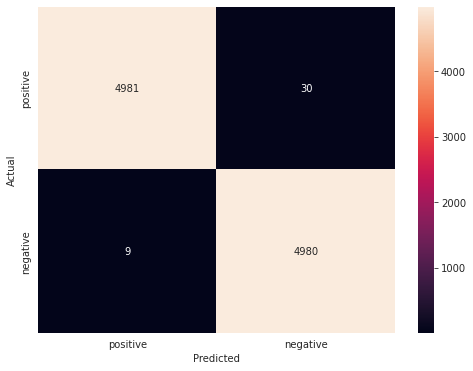

In [63]:
conf_mat = confusion_matrix(y_test, predicted)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=df.sentiment.unique(), yticklabels=df.sentiment.unique())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()
